# A Brief Exploration of LiDAR Processing in Python

# Introduction

**Li**ght **D**etection **A**nd **R**anging, commonly known by its short-form acronym of [LiDAR](https://oceanservice.noaa.gov/facts/lidar.html), is a remote sensing method that uses light in the form of pulsed laser to measure ranges (variable distances) to the earth. The recorded return light pulses are used to provide three-dimensional information about the earth and its surface characteristics. Remember that remote sensing is a method of collecting information about an object *ex-situ* (without involving physical contact).

So how do we collect information from LiDAR data? In a nutshell, the peaks from the pulse signals returning to the LiDAR sensor provide information about the kind of object the light pulse bounced off from. The image below shows the various levels of return pulse signals that are collected by the sensor.




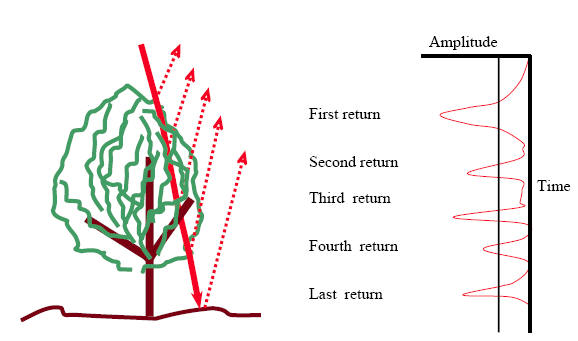

In [ ]:
from PIL import Image
import requests
url = "http://home.iitk.ac.in/~blohani/LiDAR_Tutorial/Multip8.jpg"
im = Image.open(requests.get(url, stream=True).raw)
im

Source: [Multiple Return LiDAR](http://home.iitk.ac.in/~blohani/LiDAR_Tutorial/Multiple%20return%20LiDAR.htm)

Now, in my short taste of LiDAR and its applications, I have discovered that there are as many tools for processing LiDAR as there are its applications, particularly in Python. Nevertheless, when it comes to both processing and visualization, there are hardly any tools that do both. In fact, most tools can be good in the processing bit, but it turns to be a roller-coaster when trying to visualize LiDAR data in Python. This is because some of the visualization tools may not be uniformly applicable in all platforms ie. they may be available for Jupyter but not usable in Colab. Two, some of the visualization tools are unable to handle point clouds that contain a humungous load of data points, which is a common feature of a many LiDAR datasets. Some of them just crash, or show nothing at all. AKA, silent defeat.

What's this tutorial about? It's about processing LiDAR to gain some auxilliary information, create a Digital Elevation Model (DEM), Digital Surface Model (DSM), Canopy Height Model (CHM) and individual tree mapping. Through the intermediate processes involved to get these outputs, hopefully you will gain an intuition of how to work with LiDAR data in Python.

# Check if using GPU

In [ ]:
# Check if using GPU
import tensorflow as tf
if tf.test.gpu_device_name() == '/device:GPU:0':
  print("GPU is active")
else:
  print("GPU is not active")

GPU is not active


# Connect to Google Drive

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Let's install some of the requisite libraries. For processing our LiDAR data, we will use the [whitebox tools](https://www.whiteboxgeo.com/manual/wbt_book/intro.html). There are several other LiDAR processing tools available such as Laspy, PyDAL, PyLiDAR but, as per my personal opinion, none score as highly in terms of simplicity when handling LiDAR matters compared to the whitebox package.

# Install the requisite libraries

In [ ]:
# Install whitebox
!pip install whitebox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 1.7 MB/s eta 0:00:00


In [ ]:
# Install whitebox-workflows
!pip install whitebox-workflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 8.5 MB/s eta 0:00:00


In [ ]:
# Install geemap
!pip install geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00


In [ ]:
# Install rasterio
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 54.6 MB/s eta 0:00:00


In [ ]:
# Install rioxarry
!pip install rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.2 MB/s eta 0:00:00


In [ ]:
# Install earthpy library
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.5 MB/s eta 0:00:00


# Import the requisite libraries

In [ ]:
import whitebox
import whitebox_workflows as wbw
import geemap
import rioxarray as rxr
import rasterio
import earthpy as et
import earthpy.plot as ep
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import plotting_extent

After installing all that we need, let's crack open the whitebox and use the tools for the job.

# Instantiate whitebox tools

In [ ]:
wbt = whitebox.WhiteboxTools()

Decompressing WhiteboxTools_linux_musl.zip ...
WhiteboxTools package directory: /usr/local/lib/python3.10/dist-packages/whitebox


One can get excited when working with LiDAR data. After all, the cool 3D visualizations of landscapes collected by LiDAR may make one wish it was their lifetime vocation. It's like a child experiencing a computer for the first time. However, we will not let over-excitement take the better of us. One of the first and foremost activities of a data scientist is data exploration. Before heading to the imagery, let's see a summary of our return pulses first. This helps in providing a general overview of the type of landscape we will be working with.

In [ ]:
# Let's see some info about our lidar data
# The Lidar data was downloaded from here: https://ndownloader.figshare.com/files/12395030
# The webpage for the above lidar data is from Earth data science: https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/?utm_source=pocket_reader
wbt.lidar_info(
    i="/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz",
    output="/content/drive/MyDrive/data/lidar/lidar_blog/colorad_laz_info.html"
)

./whitebox_tools --run="LidarInfo" --input='/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz' --output='/content/drive/MyDrive/data/lidar/lidar_blog/colorad_laz_info.html' --density --vlr --geokeys -v --compress_rasters=False

****************************
* Welcome to LidarInfo     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Complete! Please see /content/drive/MyDrive/data/lidar/lidar_blog/colorad_laz_info.html for output.


0

The output html file contains some summary text and tables.

Here is a snippet of it:

```python
Num. of Points (32-bit): 1480811
Number of Points by Return: [1196465, 283900, 224, 222, 0]
...

Max X: 471999.99
Min X: 471098.92
Max Y: 4428999.99
Min Y: 4428000
Max Z: 2000.51
Min Z: 1771.58
```

From the summary text, some of the key information is `Num. of Points (32-bit):`, `Max X`, `Min X`, `Max Y`, `Min Y` which correspond to the bounds of our Lidar data. The `Max Z` and `Min Z` are the maximum and minimum elevation values respectively. As if that is not enough, the `Point Return Analysis` tables provide us with statistics of the type of returns and landcover classes detected by our LiDAR sensor.

```python
Point Classification Table
Classification	Number	Percentage
1 - Unclassified	199026	13.4%
2 - Ground	804312	54.3%
5 - High vegetation	474530	32.0%
6 - Building	2943	0.2%

```

Like a child who has been gifted a computer, more often than not the manual will be briefly skeemed over before indulging in all the computer has to offer. Okay, let's cave in to our inquisitiveness. The whitebox tools also offers a method to view histogram of not only the elevation values of the LiDAR data, but other parameters as well such as class, intensity and even time.

# Histogram of Elevation Values

In [ ]:
# Plot the Elevation values of our Colorado .laz file
wbt.lidar_histogram(
    i="/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz",
    output="/content/drive/MyDrive/data/lidar/lidar_blog/colorad_elev_hist.html",
    parameter="elevation",
    clip=0 # We don't want to clip tails. show difference between original and that will suffix 2
)

./whitebox_tools --run="LidarHistogram" --input='/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz' --output='/content/drive/MyDrive/data/lidar/lidar_blog/colorad_elev_hist.html' --parameter=elevation --clip=0 -v --compress_rasters=False

*****************************
* Welcome to LidarHistogram *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
reading input LiDAR file...
Calculating min and max: 0%
Calculating min and max: 1%
Calculating min and max: 2%
Calculating min and max: 3%
Calculating min and max: 4%
Calculating min and max: 5%
Calculating min and max: 6%
Calculating min and max: 7%
Calculating min and max: 8%
Calculating min and max: 9%
Calculating min and max: 10%
Calculating min and max: 11%
Calculating min and max: 12%
Calculating min and max: 13%
Calculating min and max: 14%
Calculating min and max: 15%
Calculating min and max: 16%
Calculating min and max: 17%
Calculating min and max: 18%
Calculating 

0

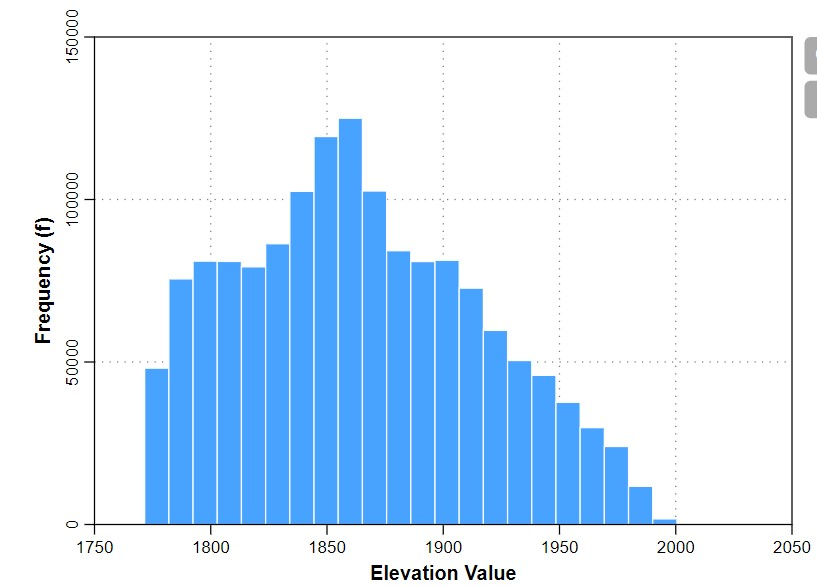

In [ ]:
im = Image.open("/content/drive/MyDrive/data/lidar/lidar_blog/hist_elev2.jpg")
im

In [ ]:
# Plot a histogram of the classes within our Colorado .laz file
wbt.lidar_histogram(
    i="/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz",
    output="/content/drive/MyDrive/data/lidar/lidar_blog/colorado_class_hist.html",
    parameter="class",
    clip=0 # We don't want to clip tails. show difference between original and that will suffix 2
)

./whitebox_tools --run="LidarHistogram" --input='/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz' --output='/content/drive/MyDrive/data/lidar/lidar_blog/colorado_class_hist.html' --parameter=class --clip=0 -v --compress_rasters=False

*****************************
* Welcome to LidarHistogram *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
reading input LiDAR file...
Calculating min and max: 0%
Calculating min and max: 1%
Calculating min and max: 2%
Calculating min and max: 3%
Calculating min and max: 4%
Calculating min and max: 5%
Calculating min and max: 6%
Calculating min and max: 7%
Calculating min and max: 8%
Calculating min and max: 9%
Calculating min and max: 10%
Calculating min and max: 11%
Calculating min and max: 12%
Calculating min and max: 13%
Calculating min and max: 14%
Calculating min and max: 15%
Calculating min and max: 16%
Calculating min and max: 17%
Calculating min and max: 18%
Calculating mi

0

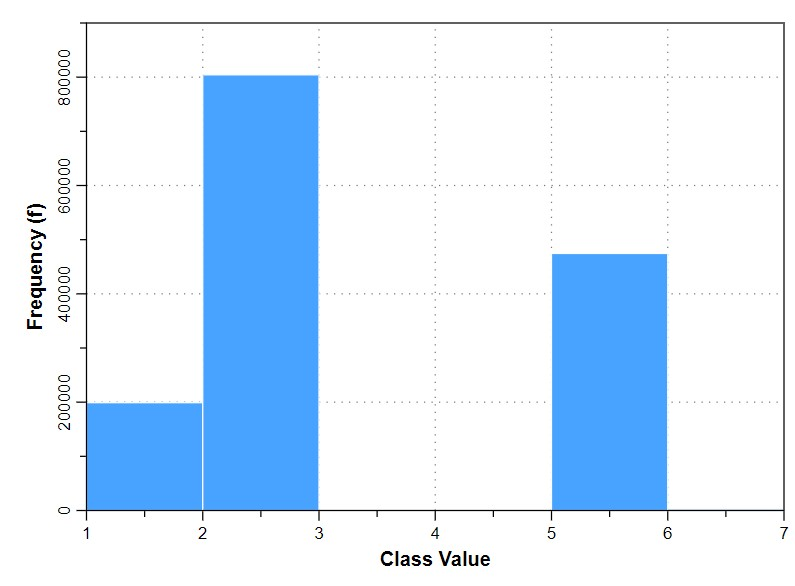

In [ ]:
im = Image.open("/content/drive/MyDrive/data/lidar/lidar_blog/hist_class.jpg")
im

# Create a DEM using IDW

Now when we got a computer back in the day (it was quite an old one, and a second hand for that matter!) we dived straight to exploring what we could use it for. Watching movies, reading a book and opening one programme after another.

Let's venture further withour LiDAR data. There are two ways of creating a Digital Elevation Model (DEM). One is to use the [Inverse Distance Weighting (IDW)](https://pro.arcgis.com/en/pro-app/latest/help/analysis/geostatistical-analyst/how-inverse-distance-weighted-interpolation-works.htm) interpolation method. [Interpolation](https://gisgeography.com/inverse-distance-weighting-idw-interpolation/) is the estimation of an unknown points using known points. The unknown points can be estimated through a radius or using a fixed number of known points surrounding the unknown point. The IDW is just a mathematical function for giving higher weights to known points closer to the unknown point than those far away. The closest points to the unknown point will have a greater say as to what value will be assigned to it.

The second method is through [Triangular Irregular Network (TIN)](https://desktop.arcgis.com/en/arcmap/latest/manage-data/tin/fundamentals-of-tin-surfaces.htm) gridding method. [Gridding](https://www.neonscience.org/resources/learning-hub/tutorials/spatial-interpolation-basics) is the process of assigning a value to every pixel where there is a point. This value may be a min, max, mean or a mathematical function of all the points. The TINs are created by connecting the derived points (vertices) through a network of edges to form a network of triangles. The various methods of creating TINs are beyond the scope of this tutorial.

Let's start by creating a DEM using the IDW interpolation method.

In [ ]:
# For type of returns, see this article: https://pro.arcgis.com/en/pro-app/3.1/help/data/las-dataset/what-is-lidar-.htm
wbt.lidar_idw_interpolation(
    i="/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz",
    output="/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem.tif",
    parameter="elevation",
    returns="last",
    resolution=1,
    exclude_cls="1, 5, 6" # We want to exclude the classes of unclassified, High Vegetation and Building respectively
)

./whitebox_tools --run="LidarIdwInterpolation" --input='/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz' --output='/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem.tif' --parameter=elevation --returns=last --resolution=1 --weight=1.0 --radius=2.5 --exclude_cls='1, 5, 6' -v --compress_rasters=False

************************************
* Welcome to LidarIdwInterpolation *
* Powered by WhiteboxTools         *
* www.whiteboxgeo.com              *
************************************
Performing interpolation...
reading input LiDAR file...
Binning points: 0%
Binning points: 1%
Binning points: 2%
Binning points: 3%
Binning points: 4%
Binning points: 5%
Binning points: 6%
Binning points: 7%
Binning points: 8%
Binning points: 9%
Binning points: 10%
Binning points: 11%
Binning points: 12%
Binning points: 13%
Binning points: 14%
Binning points: 15%
Binning points: 16%
Binning points: 17%
Binning points: 18%
Binning points: 19%
Binning points: 20%
Binning point

0

Our newly created DEM has no Coordinate Reference System (CRS). Without it, it is like a fully functioning destroyer drifting across the high seas that has no clue of its exact location in the expansive waters Let's assign the DEM a CRS. Though other methods exist, we relied on `geemap` package due to its simplicity.

You will be surprised at all the complicated code posed out there just for the simple task of assigning a CRS to a raster.


In [ ]:
# Assign a CRS
# We will use geemap for this
geemap.add_crs("/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem.tif",
               epsg=32613) # This CRS is based on one of the shapefiles within the downloaded data

Let's read our raster, now linked to a real-world location thanks to the CRS we assigned to it.

In [ ]:
# Read the raster using rioxarray
idw_dem = rxr.open_rasterio("/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem.tif",
                            masked=True)

Let's display it.

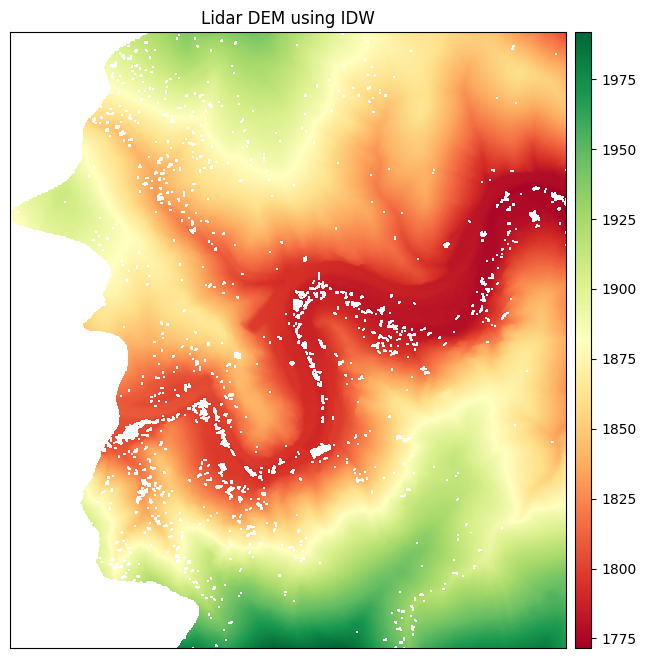

<Figure size 640x480 with 0 Axes>

In [ ]:
# View the raster
ep.plot_bands(
    arr=idw_dem,
    cmap="RdYlGn",
    figsize=(8, 8),
    title="Lidar DEM using IDW"
)

plt.show();

Notice, however, that there are some holes in our DEM. We'll fix this later.

# Create DEM using TIN

Let's repeat the same process for creating a DEM from a TIN gridding method.

In [ ]:
# Keep the same parameters as for IDW for comparison
wbt.lidar_tin_gridding(
    i="/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz",
    output="/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem.tif",
    parameter="elevation",
    returns="last",
    resolution=1,
    exclude_cls="1, 5, 6", # We want to exclude the classes of unclassified, High Vegetation and Building respectively
    max_triangle_edge_length=5 # Just selected a random number. If you leave as None, you will get huge triangles towards the edge see this pic.
)

./whitebox_tools --run="LidarTinGridding" --input='/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz' --output='/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem.tif' --parameter=elevation --returns=last --resolution=1 --exclude_cls=1, 5, 6 --max_triangle_edge_length='5' -v --compress_rasters=False

*******************************
* Welcome to LidarTINGridding *
* Powered by WhiteboxTools    *
* www.whiteboxgeo.com         *
*******************************
Performing interpolation...
Reading input LiDAR file...
Reading points: 0%
Reading points: 1%
Reading points: 2%
Reading points: 3%
Reading points: 4%
Reading points: 5%
Reading points: 6%
Reading points: 7%
Reading points: 8%
Reading points: 9%
Reading points: 10%
Reading points: 11%
Reading points: 12%
Reading points: 13%
Reading points: 14%
Reading points: 15%
Reading points: 16%
Reading points: 17%
Reading points: 18%
Reading points: 19%
Reading points: 20%
Reading points: 21%
Reading points: 22%


0

In [ ]:
# Assign a CRS
# We will use geemap for this
geemap.add_crs("/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem.tif",
               epsg=32613) # This CRS is based on one of the shapefiles within the downloaded data


In [ ]:
# Read the raster using rioxarray
tin_dem = rxr.open_rasterio("/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem.tif",
                            masked=True)

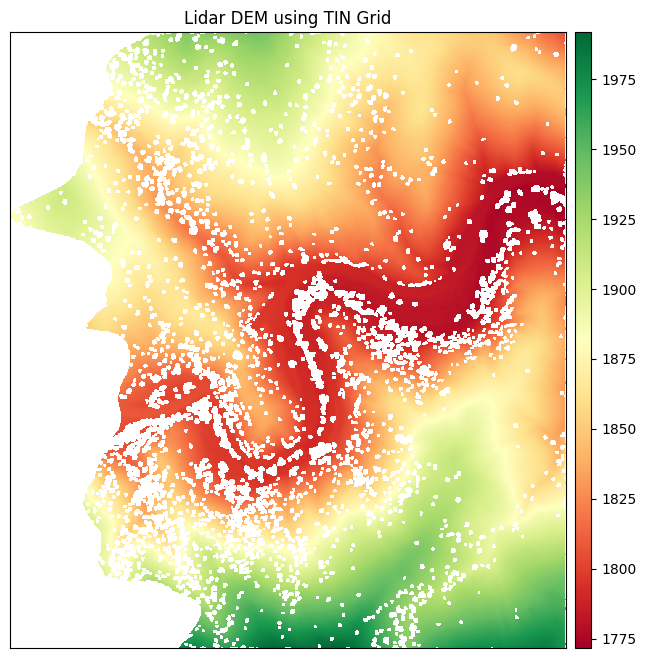

In [ ]:
# View the raster
ep.plot_bands(
    arr=tin_dem,
    cmap="RdYlGn",
    figsize=(8, 8),
    title="Lidar DEM using TIN Grid"
)

plt.show();

Even this method returns a DEM with gaps!

Now, let's proceed to fill these gaps.

In [ ]:
# Fill missing data
wbt.fill_missing_data(
    i="/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem.tif",
    output="/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem_filled.tif",
    filter=11,
    weight=2,
    no_edges=False,
)

./whitebox_tools --run="FillMissingData" --input='/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem.tif' --output='/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem_filled.tif' --filter=11 --weight=2 -v --compress_rasters=False

******************************
* Welcome to FillMissingData *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Interpolating data holes...
Interpolating data holes: 0%
Interpolating data holes: 1%
Interpolating data holes: 2%
Interpolating data holes: 3%
Interpolating data holes: 4%
Interpolating data holes: 5%
Interpolating data holes: 6%
Interpolating data holes: 7%
Interpolating data holes: 8%
Interpolating data holes: 9%
Interpolating data holes: 10%
Interpolating data holes: 11%
Interpolating data holes: 12%
Interpolating data holes: 13%
Interpolating data holes: 14%
Interpolating data holes: 15%
Interpolating data holes: 16%
Interpolating data holes: 17%
Interpolating data holes: 18%
Interp

0

In [ ]:
# Assign CRS to the filled TIN
geemap.add_crs("/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem_filled.tif",
               epsg=32613) # This CRS is based on one of the shapefiles within the downloaded data

In [ ]:
# Read the raster using rioxarray
tin_dem_filled = rxr.open_rasterio("/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem_filled.tif",
                            masked=True)

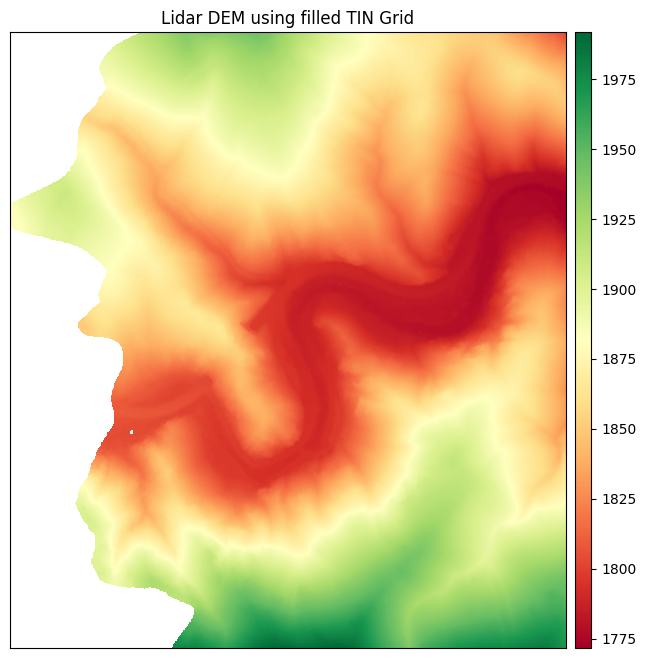

In [ ]:
# View the raster
ep.plot_bands(
    arr=tin_dem_filled,
    cmap="RdYlGn",
    figsize=(8, 8),
    title="Lidar DEM using filled TIN Grid"
)

plt.show();

Our TIN gridded DEM looks as smooth as silk.

Let's fill gaps for our IDW interpolated DEM as well.

# Fill the IDW raster

In [ ]:
# Lets also fill the IDW raster
# Fill missing data
wbt.fill_missing_data(
    i="/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem.tif",
    output="/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem_filled.tif",
    filter=11,
    weight=2,
    no_edges=False,
)

./whitebox_tools --run="FillMissingData" --input='/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem.tif' --output='/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem_filled.tif' --filter=11 --weight=2 -v --compress_rasters=False

******************************
* Welcome to FillMissingData *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Interpolating data holes...
Interpolating data holes: 0%
Interpolating data holes: 1%
Interpolating data holes: 2%
Interpolating data holes: 3%
Interpolating data holes: 4%
Interpolating data holes: 5%
Interpolating data holes: 6%
Interpolating data holes: 7%
Interpolating data holes: 8%
Interpolating data holes: 9%
Interpolating data holes: 10%
Interpolating data holes: 11%
Interpolating data holes: 12%
Interpolating data holes: 13%
Interpolating data holes: 14%
Interpolating data holes: 15%
Interpolating data holes: 16%
Interpolating data holes: 17%
Interpolating data holes: 18%
Interp

0

In [ ]:
# Assign CRS to the filled IDW
geemap.add_crs("/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem_filled.tif",
               epsg=32613) # This CRS is based on one of the shapefiles within the downloaded data

In [ ]:
# Read the raster using rioxarray
idw_dem_filled = rxr.open_rasterio("/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem_filled.tif",
                            masked=True)

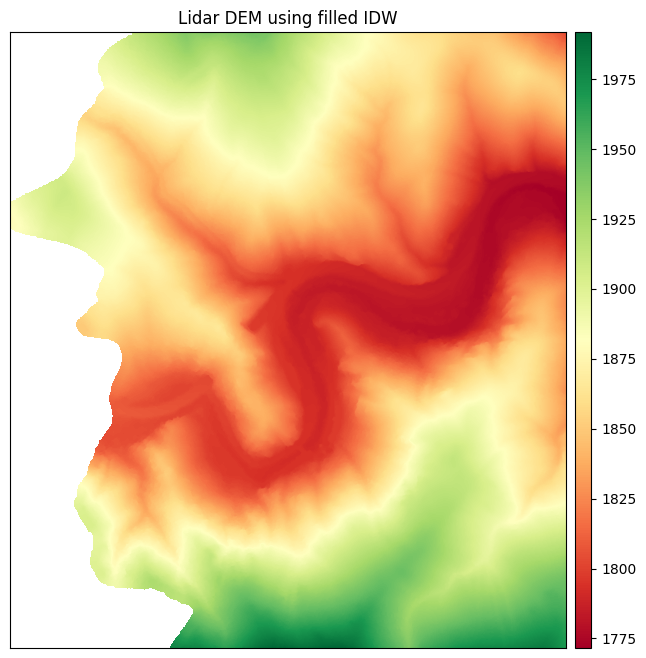

In [ ]:
# View the raster
ep.plot_bands(
    arr=idw_dem_filled,
    cmap="RdYlGn",
    figsize=(8, 8),
    title="Lidar DEM using filled IDW"
)

plt.show();

# Create the Digital Surface Model (DSM)

Unlike a DEM which is a bare-earth raster excluding non-ground features such as buildings and vegetation, a Digital Surface Model (DSM) captures the natural and built features on the earth's surface. Thus a DSM will contains vegetation, building and other non-ground features. There is also a [Digital Terrain Model (DTM)](https://gisgeography.com/dem-dsm-dtm-differences/), sometimes synonymously referred to as DEM. A DTM in some countries is a vector data set containing regularly spaced points accompanied with natural linear features disecting the earth's surface.

For this article, we only deal with the DEM and DSM which will be used to create a Canopy Height Model (CHM).

But first, let's start from the bottom-up.

Here's how to create the DSM.

In [ ]:
# Create the DSM
wbt.lidar_digital_surface_model(
    i="/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz",
    output="/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm.tif",
    resolution=1,
    radius=2.5, # Same as for IDW interpolation
    # minz=1750, # The minimum elevation in our dataset. But not much of a difference even when commented out
    max_triangle_edge_length=5 # Same as for TIN Gridding. Leaving it as None will create triangles at the edge
)

./whitebox_tools --run="LidarDigitalSurfaceModel" --input='/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz' --output='/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm.tif' --resolution=1 --radius=2.5 --max_triangle_edge_length='5' -v --compress_rasters=False

***************************************
* Welcome to LidarDigitalSurfaceModel *
* Powered by WhiteboxTools            *
* www.whiteboxgeo.com                 *
***************************************
Performing interpolation...
Reading input LiDAR file...
Reading points: 0%
Reading points: 1%
Reading points: 2%
Reading points: 3%
Reading points: 4%
Reading points: 5%
Reading points: 6%
Reading points: 7%
Reading points: 8%
Reading points: 9%
Reading points: 10%
Reading points: 11%
Reading points: 12%
Reading points: 13%
Reading points: 14%
Reading points: 15%
Reading points: 16%
Reading points: 17%
Reading points: 18%
Reading points: 19%
Reading points: 20%
Reading points: 21%
Reading point

0

In [ ]:
# Assign CRS to the DSM
geemap.add_crs("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm.tif",
               epsg=32613) # This CRS is based on one of the shapefiles within the downloaded data

In [ ]:
# Read the raster using rioxarray
dsm = rxr.open_rasterio("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm.tif",
                            masked=True)

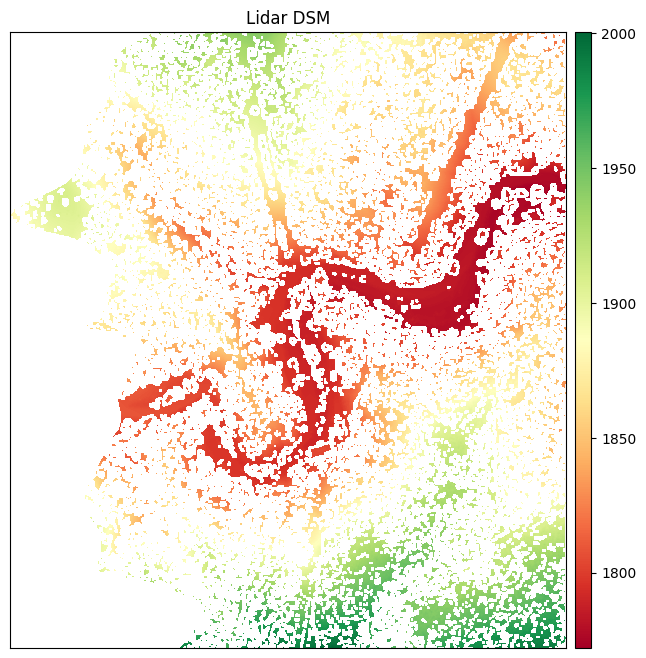

In [ ]:
# View the raster
ep.plot_bands(
    arr=dsm,
    cmap="RdYlGn",
    figsize=(8, 8),
    title="Lidar DSM"
)

plt.show();

It seems the drawback of using the whitebox tools has been the resultant rasters having gaps but we will soldier on.

In [ ]:
# Fill the DSM missing data
wbt.fill_missing_data(
    i="/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm.tif",
    output="/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm_filled.tif",
    filter=11,
    weight=2,
    no_edges=False,
)

./whitebox_tools --run="FillMissingData" --input='/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm.tif' --output='/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm_filled.tif' --filter=11 --weight=2 -v --compress_rasters=False

******************************
* Welcome to FillMissingData *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Interpolating data holes...
Interpolating data holes: 0%
Interpolating data holes: 1%
Interpolating data holes: 2%
Interpolating data holes: 3%
Interpolating data holes: 4%
Interpolating data holes: 5%
Interpolating data holes: 6%
Interpolating data holes: 7%
Interpolating data holes: 8%
Interpolating data holes: 9%
Interpolating data holes: 10%
Interpolating data holes: 11%
Interpolating data holes: 12%
Interpolating data holes: 13%
Interpolating data holes: 14%
Interpolating data holes: 15%
Interpolating data holes: 16%
Interpolating data holes: 17%
Interpolating data holes: 

0

In [ ]:
# Assign CRS to the filled DSM
geemap.add_crs("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm_filled.tif",
               epsg=32613) # This CRS is based on one of the shapefiles within the downloaded data

In [ ]:
# Read the raster using rioxarray
dsm_filled = rxr.open_rasterio("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm_filled.tif",
                            masked=True)

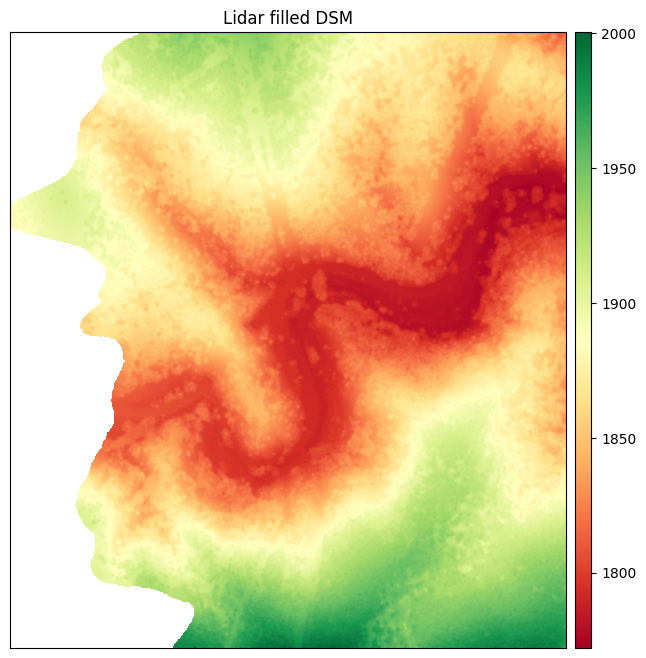

In [ ]:
# View the raster
ep.plot_bands(
    arr=dsm_filled,
    cmap="RdYlGn",
    figsize=(8, 8),
    title="Lidar filled DSM"
)

plt.show();

# Create the Canopy Height Model

A Canopy Height Model (CHM) is a raster layer that maps the height of trees (or other objects) above the ground.

The CHM is created using this formula:

```python
DSM - DEM = CHM
```

See more [here](https://www.earthdatascience.org/courses/earth-analytics/lidar-raster-data-r/lidar-chm-dem-dsm/).

We will create two CHMs, one from the IDW filled DEM and another from the TIN gridded DEM. Beauty lies in the eyes of the beholder so it is up to you to decide which best serves your interests.

In [ ]:
# Create CHM from IDW DEM
wbt.subtract("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm_filled.tif",
             "/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem_filled.tif",
             output="/content/drive/MyDrive/data/lidar/lidar_blog/colorado_chm_idw.tif")

./whitebox_tools --run="Subtract" --input1='/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm_filled.tif' --input2='/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem_filled.tif' --output='/content/drive/MyDrive/data/lidar/lidar_blog/colorado_chm_idw.tif' -v --compress_rasters=False

****************************
* Welcome to Subtract      *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress

0

In [ ]:
# Create CHM from TIN DEM
wbt.subtract("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm_filled.tif",
             "/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem_filled.tif",
             output="/content/drive/MyDrive/data/lidar/lidar_blog/colorado_chm_tin.tif")

./whitebox_tools --run="Subtract" --input1='/content/drive/MyDrive/data/lidar/lidar_blog/colorado_dsm_filled.tif' --input2='/content/drive/MyDrive/data/lidar/lidar_blog/tin_dem_filled.tif' --output='/content/drive/MyDrive/data/lidar/lidar_blog/colorado_chm_tin.tif' -v --compress_rasters=False

****************************
* Welcome to Subtract      *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress

0

In [ ]:
# Assign CRS to both CHMs
geemap.add_crs("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_chm_idw.tif",
               epsg=32613) # This CRS is based on one of the shapefiles within the downloaded data

geemap.add_crs("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_chm_tin.tif",
               epsg=32613) # This CRS is based on one of the shapefiles within the downloaded data

In [ ]:
# Read both CHM rasters using rioxarray
chm_idw = rxr.open_rasterio("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_chm_idw.tif",
                            masked=True)

chm_tin = rxr.open_rasterio("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_chm_tin.tif",
                            masked=True)

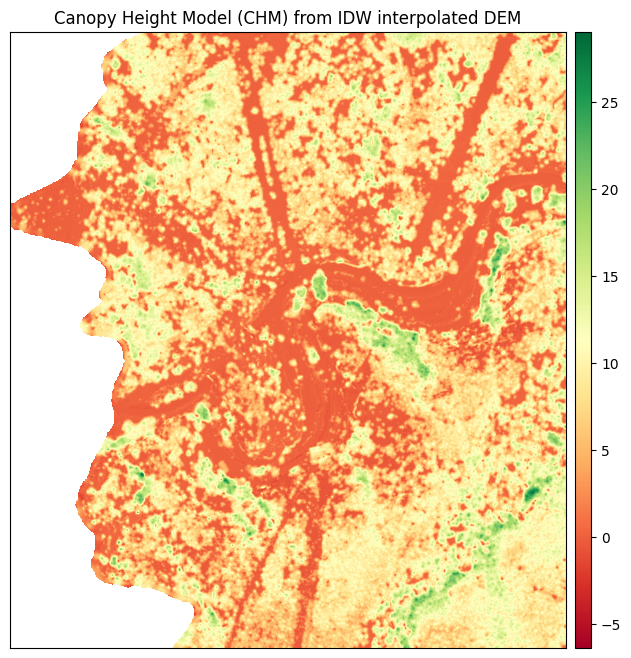

In [ ]:
# Plot the CHM from IDW Interpolated DEM
ep.plot_bands(
    arr=chm_idw,
    cmap="RdYlGn",
    figsize=(8, 8),
    title="Canopy Height Model (CHM) from IDW interpolated DEM"
)

plt.show();


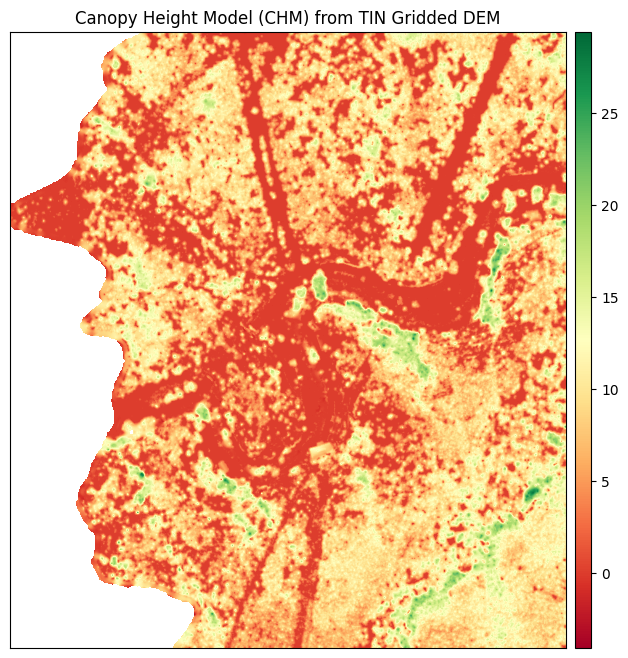

In [ ]:
# Plot the CHM from TIN Gridded DEM
ep.plot_bands(
    arr=chm_tin,
    cmap="RdYlGn",
    figsize=(8, 8),
    title="Canopy Height Model (CHM) from TIN Gridded DEM"
)

plt.show();

# Individual Tree Mapping

Now, as a data scientist, we can get distracted in two ways. 1) Noticing the various possibilities that can be derived by the data in question, and/or the tools used, and 2) when one is too fatigued from diminishing mental bandwidth and you need something to distract you from the never ending programming problems. For this exercise, the former took precedence.

Thanks to whitebox, one can do individual tree detection from the LiDAR data. Remember when we mentioned that one can know the type of landcover classes from the returned pulse signals? Vegetation is one of them. A full list of the possible LiDAR return signals is provided for [here](https://desktop.arcgis.com/en/arcmap/latest/manage-data/las-dataset/lidar-point-classification.htm).

Performing individual tree detection from LiDAR is two fold.

- Step 1: Normalize the data - this method is to assign ground points as 0, and all other points whose Z-value is above the ground a value of 1. This helps in detecting non-ground objects.

- Step 2: Individual tree detection - this is the process of identifying the points that are highly associated with the tops of trees.

Let's pass through this phases in brief. Like a child who eventually gets fatigued of independently learning their computer without the manual, we are also getting tired and need to bring this enlightening venture, like the eager child, to a close.

## Normalize the Lidar data

In [ ]:
# Normalize the Lidar data
# A normalized point cloud is one for which the point z-values represent height above the ground surface rather than
# raw elevation values. Thus, a point that falls on the ground surface will have a z-value of zero and vegetation points,
# and points associated with other off-terrain objects, have positive, non-zero z-values.
# See: https://www.whiteboxgeo.com/manual/wbt_book/available_tools/lidar_tools.html#normalizelidar

wbt.normalize_lidar(
    i="/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz",
    output="/content/drive/MyDrive/data/lidar/lidar_blog/colorado_normalized.las",
    dtm="/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem_filled.tif", # Personal choice is that the IDW filled DEM is better...it had zero holes
)


./whitebox_tools --run="NormalizeLidar" --input='/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz' --output='/content/drive/MyDrive/data/lidar/lidar_blog/colorado_normalized.las' --dtm='/content/drive/MyDrive/data/lidar/lidar_blog/idw_dem_filled.tif' -v --compress_rasters=False

*****************************
* Welcome to NormalizeLidar *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Pro

0

## Individual Tree Detection

We will only consider those points that represent the vegetation class. This is specified by the parameter: `only_use_veg=True`.

In [ ]:
# Detect trees
wbt.individual_tree_detection(
    i="/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz",
    output="/content/drive/MyDrive/data/lidar/lidar_blog/colorado_trees.shp",
    min_search_radius=2,
    min_height=5, # Based on FAO, trees have minimum height of 5m
    max_search_radius="7",
    max_height="20",
    only_use_veg=True
)

./whitebox_tools --run="IndividualTreeDetection" --input='/content/drive/MyDrive/data/lidar/2013_BLDR_flood_2013100814_471000_4428000.laz' --output='/content/drive/MyDrive/data/lidar/lidar_blog/colorado_trees.shp' --min_search_radius=2 --min_height=5 --max_search_radius=7 --max_height=20 --only_use_veg -v --compress_rasters=False

**************************************
* Welcome to IndividualTreeDetection *
* Powered by WhiteboxTools           *
* www.whiteboxgeo.com                *
**************************************
Reading lidar points...
Building kd-tree...
Locating tree tops...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 

0

In [ ]:
# Load the individually detected trees
colorado_trees = gpd.read_file("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_trees.shp")

# Assign a CRS to this shapefile
colorado_trees.crs = "epsg:32613"

In [ ]:
# Save this shapefile for further use
colorado_trees.to_file("/content/drive/MyDrive/data/lidar/lidar_blog/colorado_trees_32613.shp")

In [ ]:
# Get dimensions of CHM. Useful in getting the extent
# chm_idw

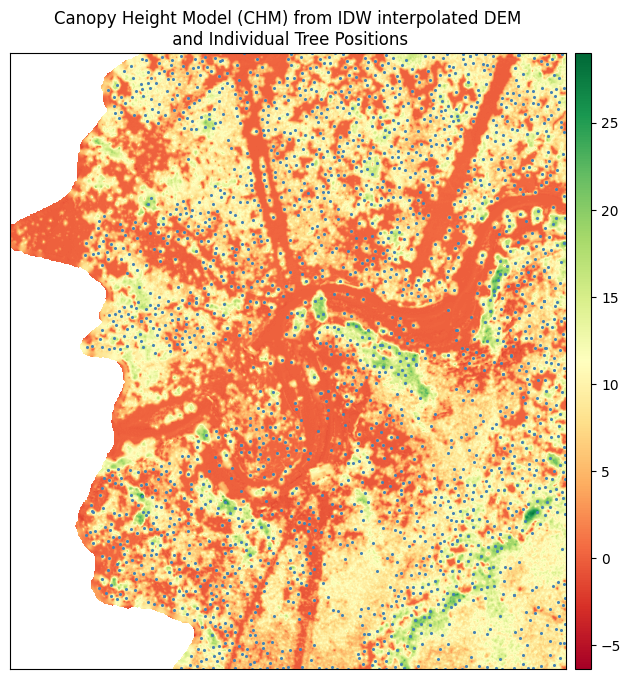

In [ ]:
# Plot the trees shapefile overlying the CHM from IDW DEM

fig, ax = plt.subplots(figsize=(12, 8))

# Get plotting extent of CHM
chm_extent = plotting_extent(chm_idw[0],
                             chm_idw.rio.transform())

# Plot the CHM from IDW Interpolated DEM
ep.plot_bands(
    arr=chm_idw,
    cmap="RdYlGn",
    figsize=(8, 8),
    title="Canopy Height Model (CHM) from IDW interpolated DEM\n and Individual Tree Positions",
    extent=chm_extent,
    ax=ax
)

colorado_trees.plot(color="steelblue",
                    ax=ax,
                    markersize=1.5)

plt.show();

One can go a step further and visualize the resulting vector set containing the tree points in Qgis. From the attribute table when viewing the tree vector data in Qgis, our Area of Interest (AOI) had 2049 trees.

Are most of the points trees? A good deal look so. Play around with parameters related to radius to see any change in the results.

Let's close for the day. Even the eager child shuts down the computer when their mind goes nump from all the unconstrained click-and-open mania. So let's stop here!

# Conclusion

In this article, we saw what LiDAR is and how it is collected. The peaks from the return pulses provide information on the object struck by the light pulse. We did a scoping review of the various Pythonic tools of processing LiDAR before settling on the whitebox package. Before embarking on deep LiDAR analysis, we started by exploring the metadata of our LiDAR data from which we had a glimpse of the bounds, landcover classes and range of elevation values within our data. We thereafter proceeded to create Digital Elevation Models (DEMs), a Digital Surface Model (DSM), and Canopy Height Model (CHM). In the process of creating DEMs, we briefly touched on the two main methods of creating DEMs. Lastly, we saw how LiDAR data can be a cheaper, convenient and straightforward source of extracting individual tree points.

Like a child who proceeded on an unplanned crash course of learning their computer without relying on a manual, this was one such kind. But fulfilling it was, don't you think?!
